In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

from toy_samples import gaussian_samples
from covariance import logX_mu, logX_covinv_chol, points_at_iteration, logPr

# Load test samples
from tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")

$\Pr (t_k) = n_k t^{n_k - 1}$

Use inverse transform sampling; $\log \frac{P}{n_k} = (n_k - 1) \log t$

$$\log t = \frac{1}{n_k - 1} \log \frac{P}{n_k}$$

Sample 5 points of $t$, take log and add them together => log X

In [7]:
samples = gaussian_samples(nlive=500, ndims=10, sigma=0.1)

In [8]:
iteration = 1000
points = points_at_iteration(samples, iteration)
logL = np.array(points.logL)
nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)

#### Random drawing of logt

In [74]:
def logt_sample(n):
    p = np.random.rand()
    return 1/n * np.log(p)
logt_sample = np.vectorize(logt_sample)

In [158]:
logt_samples = logt_sample(nlive*np.ones(iterations))
logXs = np.cumsum(logt_samples)
X = np.exp(logXs)

In [ ]:
# Show that logt_sample generates correct distribution
nk = 15
samples_taken = 10000
t = np.linspace(0, 1, 100)
plt.hist(np.exp(logt_sample(nk * np.ones(samples_taken))), bins=100, density=True);
plt.plot(t, nk*t**(nk-1))
plt.xlabel("t")
plt.ylabel("P(t)");

In [161]:
def generate_logXs(nlive, iterations):
    logt_samples = logt_sample(nlive*np.ones(iterations))
    logXs = np.cumsum(logt_samples)
    return logXs

#### Compare predictions to actual logX

In [65]:
from covariance import optimise_pr_cg, logX_model
params_cg = optimise_pr_cg(logL, mean, covinv, [-0.1, 5, 0.1]).x
logX_predict_cg = logX_model(logL, *params_cg)

In [66]:
from lm_partial import analytic_lm_params
params_ls = analytic_lm_params(logL, np.exp(mean), 10)
logX_predict_ls = logX_model(logL, *params_ls)

In [70]:
coords = points.iloc[:, 0:10]

In [79]:
r_actual = np.sqrt((coords**2).sum(axis=1))
X_actual = r_actual ** 10

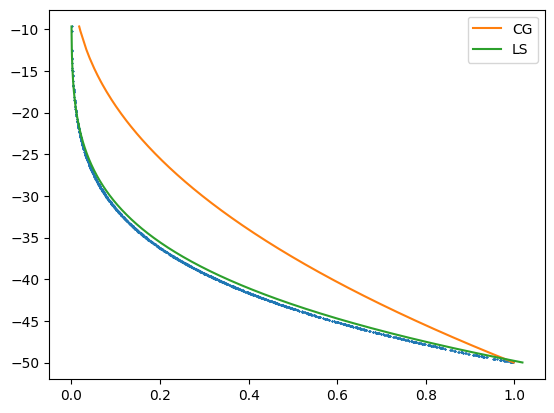

In [80]:
plt.plot(X_actual, logL, 'x', ms=1)
plt.plot(np.exp(logX_predict_cg), logL, label='CG')
plt.plot(np.exp(logX_predict_ls), logL, label='LS')
plt.legend()

#### Toy problem where underlying X distribution is exactly a multivariate Gaussian

Test whether approach to maximise logPr gives a better answer than least squares - it does. Tried for y = ax^2 and y = log(ax)

In [779]:
def y_func(x, theta):
    return np.log(theta*x)

def y_inverse(y, theta):
    return 1/theta * np.exp(y)

In [780]:
from covariance import logPr
from scipy.optimize import minimize
def optimise_pr_general(y, mean, cov_inv, x0):
    """Optimise correlated gaussian probability as a function of the parameters (logLmax, d, sigma)
    
    Inputs: logL (datapoints), mean, cov_inv of the areas logX, initial guess for the parameters x0
    Outputs: solution object for parameters (logLmax, d, sigma)"""
    def func(theta):
        x = y_inverse(y, theta)
        return - logPr(x, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

In [787]:
points = 100
mean = np.linspace(5, 100, points)
L = np.random.rand(points, points)
covrand = L @ L.T
covrand = covrand/covrand.mean()
covinvrand = np.linalg.inv(covrand)

In [790]:
mean

array([  5.        ,   5.95959596,   6.91919192,   7.87878788,
         8.83838384,   9.7979798 ,  10.75757576,  11.71717172,
        12.67676768,  13.63636364,  14.5959596 ,  15.55555556,
        16.51515152,  17.47474747,  18.43434343,  19.39393939,
        20.35353535,  21.31313131,  22.27272727,  23.23232323,
        24.19191919,  25.15151515,  26.11111111,  27.07070707,
        28.03030303,  28.98989899,  29.94949495,  30.90909091,
        31.86868687,  32.82828283,  33.78787879,  34.74747475,
        35.70707071,  36.66666667,  37.62626263,  38.58585859,
        39.54545455,  40.50505051,  41.46464646,  42.42424242,
        43.38383838,  44.34343434,  45.3030303 ,  46.26262626,
        47.22222222,  48.18181818,  49.14141414,  50.1010101 ,
        51.06060606,  52.02020202,  52.97979798,  53.93939394,
        54.8989899 ,  55.85858586,  56.81818182,  57.77777778,
        58.73737374,  59.6969697 ,  60.65656566,  61.61616162,
        62.57575758,  63.53535354,  64.49494949,  65.45

In [788]:
cg = []
ls = []
theta_actual = 4
for i in range(50):
    x_actual = np.random.multivariate_normal(mean, covrand)
    y = y_func(x_actual, theta_actual)

    a_cg, = optimise_pr_general(y, mean, covinvrand, 2).x
    a_ls, = optimise_pr_general(y, mean, np.diag(np.ones_like(mean)), 2).x

    # if abs(a_cg - theta_actual) < abs(a_ls - theta_actual):
    #     cg += 1
    # else:
    #     ls += 1
    cg.append(a_cg)
    ls.append(a_ls)
# print(f"CG: {cg}, LS:{ls}")

In [789]:
cg = np.array(cg)
ls = np.array(ls)
print(f"CG: {cg.mean():.4f} +/- {cg.std():.4f}")
print(f"LS: {ls.mean():.2f} +/- {ls.std():.2f}")

CG: 4.0000 +/- 0.0001
LS: 3.99 +/- 0.06


#### Now let's generate logL from X based on the approximate multivariate Gaussian

See if CG still gets better results; if so then problem lies in assuming multivariate Gaussian describes X distribution

It doesn't! Problem is somewhere between here and above case

Things to try:

- Get rid of sigma; effectively try above case with $X^{2/d}$ - CG still bad

- Try above case with NS covariance matrix

- More standard covariance matrices to try?

NOTEBOOKS: HYPOTHESIS DATA CONCLUSIONS

Cells: IDEA EXECUTION OUTPUT; if no output combine with following cell

Caching functions; each rerun of notebook should be fast e.g. with pickle

In [75]:
def y_func(X, theta):
    return theta * X

def y_inverse(Y, theta):
    return Y / theta

def minimise_theta(Y, mean, cov_inv, theta0):
    def func(theta):
        X = y_inverse(Y, theta)
        return - logPr(X, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, theta0)
    return solution

def optimise_pr_cg(logL, mean, cov_inv, x0):
    def func(theta):
        logX = logX_func(logL, theta)
        return - logPr(logX, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

In [14]:
iteration = 10
nk = 200 * np.ones(iteration)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
cov = np.linalg.inv(covinv)

1.8665473498496804e-54
[16.96308245] [10.66831329]


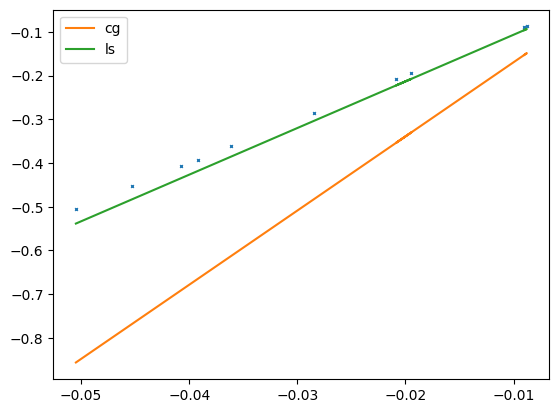

In [19]:
L = np.random.rand(iteration, iteration)
cov_random = (L @ L.T)/10**5
covinv_random = np.linalg.inv(cov)
print(np.linalg.det(cov_random))

X_actual = np.exp(np.random.multivariate_normal(mean, cov_random))
d_actual, sigma_actual = 10, 0.1
logL = logL_func(X_actual, d_actual)

logX_actual = np.log(X_actual)
Y = y_func(logX_actual, 10)

c = minimise_theta(Y, mean, covinv_random, 10).x
l = minimise_theta(Y, mean, np.diag(np.ones_like(mean)), 10).x
print(c, l)
plt.plot(logX_actual, 10*logX_actual, 'x', ms=2)
plt.plot(logX_actual, c*logX_actual, label='cg')
plt.plot(logX_actual, l*logX_actual, label='ls')
plt.legend();

In [507]:
params_cg = optimise_pr_cg(logL, mean, covinv, 8).x
params_ls = optimise_pr_cg(logL, mean, np.diag(np.ones_like(mean)), 8).x

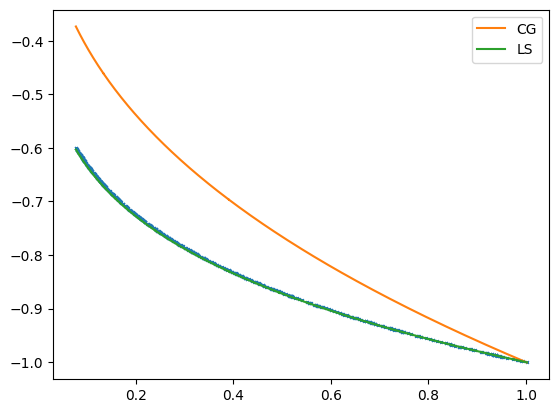

In [515]:
plt.plot(X_actual, logL_func(X_actual, d_actual), 'x', ms=2)
plt.plot(X_actual, logL_func(X_actual, params_cg,), label='CG')
plt.plot(X_actual, logL_func(X_actual, params_ls,), label='LS')
plt.legend()

In [508]:
params_cg, params_ls

(array([5.19433953]), array([10.11991]))

In [99]:
def logL_X(X, theta):
    d = theta
    return - X**(d)

def X_logL(logL, theta):
    d = theta
    return np.exp(1/d * np.log(-logL))

def optimise_pr_cg(logL, mean, cov_inv, x0):
    def func(theta):
        X = X_logL(logL, theta)
        return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

#### Using the mean of X instead of logX to reduce degeneracies

In [242]:
# Taking logX is the problem
def y_func(X, theta):
    return theta * np.log(X)

def y_inverse(Y, theta):
    return np.exp(Y / theta)

def minimise_theta(Y, mean, cov_inv, theta0):
    def func(theta):
        X = y_inverse(Y, theta)
        return - logPr(X, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, theta0)
    return solution

iteration = 1000
nk = 10000 * np.ones(iteration)
logX_mean = logX_mu(nk)
logX_covinv = logX_covinv_chol(nk)
logX_cov = np.linalg.inv(logX_covinv)
X_mean = np.exp(logX_mean)

X_actual = np.random.multivariate_normal(X_mean, logX_cov)
Y_X = y_func(X_actual, 10)

c = minimise_theta(Y_X, X_mean, logX_covinv, 10).x
l = minimise_theta(Y_X, X_mean, np.eye(len(logX_mean)), 10).x
print(c, l)

[22.27895417] [9.64171903]


In [250]:
# Using generated logX also the problem
def y_func(logX, theta):
    return theta * logX

def y_inverse(Y, theta):
    return Y / theta

logX_actual = np.random.multivariate_normal(logX_mean, logX_cov)
Y_logX = y_func(logX_actual, 10)

c = minimise_theta(Y_logX, logX_mean, logX_covinv, 10).x
l = minimise_theta(Y_logX, logX_mean, np.eye(len(logX_mean)), 10).x
print(c, l)

[18.71786574] [9.33994915]


In [247]:
# Taking logX is the problem
def y_func(X, theta):
    return np.exp(theta*X)

def y_inverse(Y, theta):
    return 1/theta * np.log(Y)

iteration = 200
nk = 10000 * np.ones(iteration)
logX_mean = logX_mu(nk)
logX_covinv = logX_covinv_chol(nk)
logX_cov = np.linalg.inv(logX_covinv)
X_mean = np.exp(logX_mean)

X_actual = np.random.multivariate_normal(X_mean, logX_cov)
Y_X = y_func(X_actual, 10)

c = minimise_theta(Y_X, X_mean, logX_covinv, 10).x
l = minimise_theta(Y_X, X_mean, np.eye(len(logX_mean)), 10).x
print(c, l)

[10.00033578] [9.988771]


Taking logX messes up the distribution